In [222]:
# import class for financial data
import yfinance as yf

# import class for data manipulation and analysis
import pandas as pd
import numpy as np

# import class for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import class for machine learning
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# import class for evaluation metrics
from sklearn.metrics import root_mean_squared_error, r2_score

# import class for connection to broker 
from ib_insync import *
import nest_asyncio

# import class(s) for supportive functions
import datetime as dt
from scipy.stats import randint, uniform


In [223]:
current_date = dt.datetime.now().strftime('%Y-%m-%d')
ticker = 'NVDA'
df = yf.download(ticker, start = '2020-01-01', end = current_date)

[*********************100%***********************]  1 of 1 completed


In [224]:
df.columns = ['close', 'high', 'low', 'open', 'volume']

In [225]:
%%markdown 
## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



## **Feature selection and why:** 

### **5-day moving average:**
1. Captures short-term trends in stock prices.
2. Helps smooth out daily price fluctuations.

### **15-day moving average:**
1. Captures medium-term trends.
2. Reduces noise from daily price movements typically seen in the 3-day moving average.

### **50-day moving average:**
1. Captures long-term trends in stock prices.
2. Provides a broader perspective on stock performance.

### **5-day volatility:**
1. Measures the variability of stock prices over a 5-day period.
2. Indicates the risk associated with the stock.



In [ ]:
df['5MA_Returns'] = df['close'].rolling(window=5).mean().pct_change(periods=5)
df['15MA_Returns'] = df['close'].rolling(window=15).mean().pct_change(periods=15)
df['50MA_Returns'] = df['close'].rolling(window=50).mean().pct_change(periods=50)
df['5Volatility'] = df['close'].rolling(window=5).std()
df['next_close'] = df['close'].shift(-1)
df.dropna(inplace=True)
df

,close,high,low,open,volume,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,next_close
Date,,,,,,,,,,
2020-05-26,8.685749,9.148047,8.640167,9.123138,770780000,0.084221,0.142570,0.097290,0.131916,8.493956
2020-05-27,8.493956,8.601060,7.967395,8.593339,1175892000,0.051545,0.150902,0.112287,0.201071,8.455848
2020-05-28,8.455848,8.728343,8.348492,8.381371,734896000,0.011255,0.156003,0.123458,0.216071,8.842919
2020-05-29,8.842919,8.842919,8.453853,8.523098,745256000,-0.003654,0.164813,0.138385,0.228282,8.773925
2020-06-01,8.773925,8.808298,8.657604,8.800826,389876000,-0.020653,0.168523,0.151717,0.170218,8.792856
...,...,...,...,...,...,...,...,...,...,...
2025-05-19,135.570007,135.869995,132.389999,132.389999,193154600,0.142014,0.149474,-0.141653,2.410673,134.380005
2025-05-20,134.380005,134.580002,132.619995,134.289993,161514200,0.118392,0.157188,-0.133194,0.489825,131.800003
2025-05-21,131.800003,137.399994,130.589996,133.059998,270608700,0.079850,0.162347,-0.125483,1.525951,132.830002


In [227]:
df.describe()

,close,high,low,open,volume,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,next_close
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000
mean,47.450585,48.348827,46.459850,47.450767,4.257626e+08,0.012673,0.038493,0.141897,1.385725,47.551472
std,43.119048,43.954301,42.221326,43.172075,1.810562e+08,0.057618,0.104982,0.207470,1.668273,43.176593
min,8.455848,8.601060,7.967395,8.381371,9.788400e+07,-0.154879,-0.229242,-0.279930,0.041952,8.455848
25%,15.346696,15.664219,15.091277,15.339960,2.907080e+08,-0.026497,-0.032071,-0.000879,0.373552,15.350925
50%,24.670668,25.211653,23.965027,24.759766,4.036860e+08,0.014594,0.028001,0.146866,0.692824,24.684675
75%,76.174965,78.545503,74.192142,74.996840,5.248180e+08,0.051517,0.109066,0.308947,1.643660,77.633858
max,149.416245,153.115916,147.806407,153.015919,1.543911e+09,0.252968,0.336621,0.597735,12.714196,149.416245


In [261]:
df_corr = df[['5MA_Returns', '15MA_Returns', '50MA_Returns', '5Volatility', 'close', 'next_close']].corr()
df_corr

,5MA_Returns,15MA_Returns,50MA_Returns,5Volatility,close,next_close
5MA_Returns,1.000000,0.310539,0.096020,-0.035512,0.043059,0.042330
15MA_Returns,0.310539,1.000000,0.298758,-0.036306,0.023010,0.023155
50MA_Returns,0.096020,0.298758,1.000000,-0.002936,0.063340,0.063472
5Volatility,-0.035512,-0.036306,-0.002936,1.000000,0.779466,0.779583
close,0.043059,0.023010,0.063340,0.779466,1.000000,0.998661
next_close,0.042330,0.023155,0.063472,0.779583,0.998661,1.000000


In [262]:
def find_highest_correlation_pair(df):
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    corr_series = upper_triangle.stack()
    max_corr_index = corr_series.abs().idxmax()
    return max_corr_index, corr_series[max_corr_index]

highest_corr_pair, highest_corr_value = find_highest_correlation_pair(df[df_corr.columns])
print(f'Highest correlation pair: {highest_corr_pair} with correlation value: {highest_corr_value:.2f}')

Highest correlation pair: ('close', 'next_close') with correlation value: 1.00


In [285]:
x_train, x_test, y_train, y_test = train_test_split(
    df[df_corr.columns[:-1]],
    #df,  
    df['next_close'], 
    test_size=0.2, 
    shuffle=False
    )

In [272]:
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestRegressor()

In [273]:
# Hyperparameter tuning
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10), 
    'criterion': ['squared_error','absolute_error'], 
    'max_features': ['sqrt', 'log2', None, 0.3, 0.5],
    'bootstrap': [True, False]
}

In [274]:
search_cv = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter=50, 
    cv=tscv, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2, 
    random_state=42, 
    return_train_score=True
)

In [275]:
search_cv.fit(x_train, y_train)
best_rf = search_cv.best_estimator_
y_pred = best_rf.predict(x_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.3s
[CV] END bootstrap=True, criterion=squared_error, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.4s
[CV] END bootstrap=True, criterion=squared_error, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estimators=153; total time=   0.5s
[CV] END bootstrap=True, criterion=absolute_error, max_depth=33, max_features=None, min_samples_leaf=8, min_samples_split=8, n_estimators=171; total time=   0.7s
[CV] END bootstrap=False, criterion=squared_error, max_depth=26, max_features=0.5, min_samples_leaf=2, min_samples_split=13, n_estimators=207; total time=   0.3s
[CV] END bootstrap=True, criterion=squared_error, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=5, n_estim

In [276]:
df_cv = pd.DataFrame(search_cv.cv_results_)
df_cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.940981,1.854840,0.026185,0.010696,True,absolute_error,33,None,8,8,171,"{'bootstrap': True, 'criterion': 'absolute_err...",-20.073053,-21.452494,-0.027757,-73.302027,-693.091856,-161.589438,266.854610,34,-0.014865,-0.025516,-0.021538,-0.011503,-0.043829,-0.023450,0.011311
1,0.535471,0.176987,0.016724,0.004545,True,squared_error,15,None,8,5,153,"{'bootstrap': True, 'criterion': 'squared_erro...",-19.818261,-21.459232,-0.023906,-71.484586,-678.025539,-158.162305,261.000141,20,-0.015014,-0.019535,-0.028270,-0.015831,-0.038011,-0.023332,0.008715
2,0.676364,0.339479,0.023979,0.008052,False,squared_error,26,0.5,2,13,207,"{'bootstrap': False, 'criterion': 'squared_err...",-19.026694,-21.225622,-0.074794,-71.099390,-643.023585,-150.890017,247.187385,9,-0.007374,-0.011144,-0.022027,-0.017393,-0.023853,-0.016358,0.006282
3,1.630408,1.052226,0.015281,0.007743,False,absolute_error,25,sqrt,6,13,138,"{'bootstrap': False, 'criterion': 'absolute_er...",-20.433225,-22.643334,-0.243469,-76.015957,-674.933848,-158.853967,259.257211,23,-0.018064,-0.031983,-0.076859,-0.066820,-0.108006,-0.060346,0.032182
4,0.214582,0.059228,0.013749,0.003637,True,squared_error,46,0.3,3,13,104,"{'bootstrap': True, 'criterion': 'squared_erro...",-20.572569,-23.284573,-0.226714,-77.579770,-694.416482,-163.216021,266.833647,36,-0.023464,-0.035801,-0.094144,-0.085411,-0.131912,-0.074146,0.039756
5,1.426545,1.026725,0.013386,0.005590,False,absolute_error,7,0.5,3,8,70,"{'bootstrap': False, 'criterion': 'absolute_er...",-18.743914,-20.110505,-0.086915,-67.250674,-647.199376,-150.678277,249.249170,8,-0.003562,-0.008227,-0.020259,-0.015998,-0.036509,-0.016911,0.011400
6,0.549206,0.162444,0.048543,0.041353,True,squared_error,22,0.3,9,15,291,"{'bootstrap': True, 'criterion': 'squared_erro...",-21.128516,-24.288463,-0.231617,-84.528221,-713.197732,-168.674910,273.706520,49,-0.043034,-0.061980,-0.148956,-0.128126,-0.196380,-0.115695,0.056455
7,0.858732,0.360338,0.033118,0.013723,False,squared_error,30,0.5,2,16,237,"{'bootstrap': False, 'criterion': 'squared_err...",-19.726708,-21.322381,-0.099104,-71.233666,-644.058573,-151.288086,247.503152,10,-0.013437,-0.015104,-0.031709,-0.024674,-0.035212,-0.024027,0.008675
8,2.087239,1.170026,0.019534,0.008340,True,absolute_error,12,None,1,5,99,"{'bootstrap': True, 'criterion': 'absolute_err...",-18.129844,-19.608347,-0.005110,-63.454734,-636.104895,-147.460586,245.212560,4,-0.001584,-0.001918,-0.002372,-0.001323,-0.005135,-0.002466,0.001380
9,3.022450,1.719235,0.030032,0.004434,False,absolute_error,6,log2,4,19,267,"{'bootstrap': False, 'criterion': 'absolute_er...",-20.407085,-23.164582,-0.254260,-77.634545,-694.801914,-163.252477,267.010516,37,-0.023965,-0.047469,-0.108733,-0.099078,-0.175874,-0.091024,0.052862


Text(0, 0.5, 'Mean Test Score (Negative MSE)')

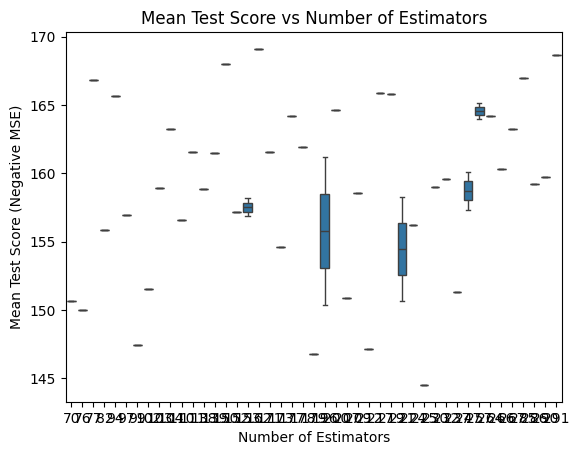

In [277]:
sns.boxplot(x=df_cv['param_n_estimators'], y=-df_cv['mean_test_score'])
plt.title('Mean Test Score vs Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score (Negative MSE)')

In [280]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
cv_rmse = np.sqrt(-search_cv.best_score_)
print(f'Best parameters: {search_cv.best_params_}')
print(f'Best score: {search_cv.best_score_:.2f}')
print(f"CV RMSE: {cv_rmse:.2f}")
print(f'RMSE: {rmse:.2f}')
print(f'R^2: {r2:.2f}')

Best parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 24, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}
Best score: -144.52
CV RMSE: 12.02
RMSE: 32.27
R^2: -5.36


Linear Regression RMSE: 4.53
Linear Regression R^2: 0.87


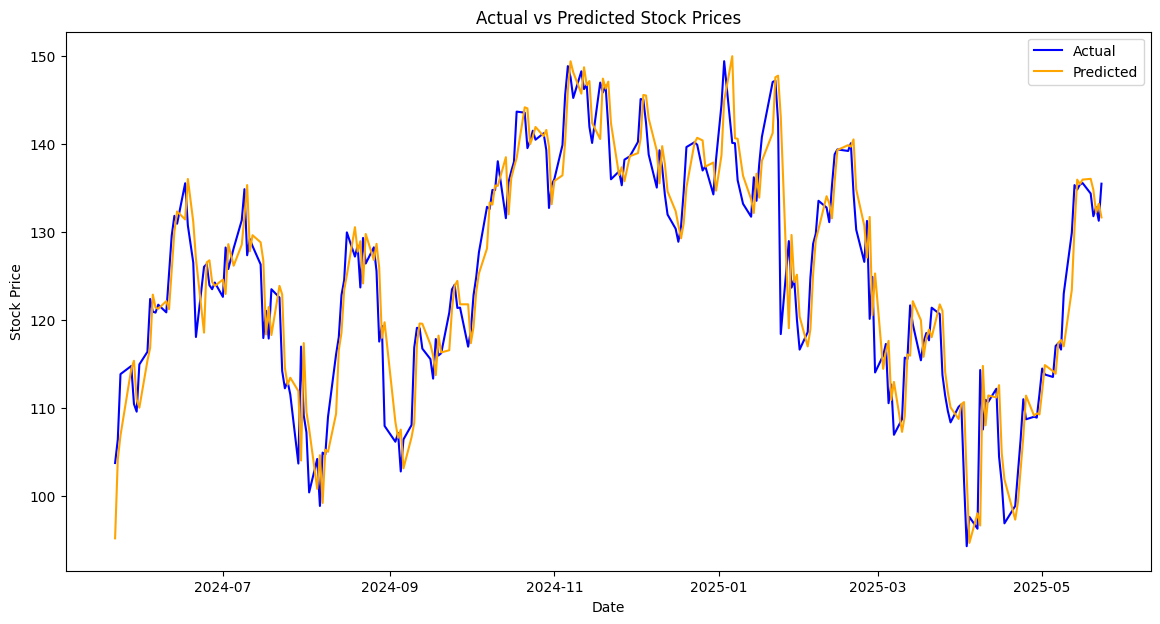

In [286]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f'Linear Regression RMSE: {rmse_lr:.2f}')
print(f'Linear Regression R^2: {r2_lr:.2f}')
plt.figure(figsize=(14, 7))
plt.plot(x_test.index, y_test, label='Actual', color='blue')
plt.plot(x_test.index, y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [176]:
#TODO 6: Visulalize linear test results

In [177]:
#TODO 7: Create buy and sell signals based on predictions

In [178]:
#TODO 8: Visualize the buy and sell signals on the stock price chart

In [179]:
#TODO 9: Evaluate the model's performance using Sharpe Ratio, total return vs buy and hold strategy.

In [180]:
#TODO 10: Using the buy and sell signals to send orders to the broker